### Building Model

In [38]:
# imports for building the network
from tensorflow import reduce_sum
from tensorflow.keras.backend import pow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Add, Flatten
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
import cv2

In [39]:
# defining configuration parameters
img_size = 256 # image resize size
batch_size = 32 # batch size for training unet
k_size = 3 # kernel size 3x3
val_size = .30 # split of training set between train and validation set
no_pneumo_drop = 0 # dropping some data to balance the class a little bit better

In [40]:
#Reference - https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

"The function below creates a Data-Generator which helps us loading the data into our model"

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_path_list, labels, batch_size=32, 
                 img_size=256, channels=1, shuffle=True):
        self.file_path_list = file_path_list
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.channels = channels
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        'denotes the number of batches per epoch'
        return int(np.floor(len(self.file_path_list)) / self.batch_size)
    
    def __getitem__(self, index):
        'generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # get list of IDs
        file_path_list_temp = [self.file_path_list[k] for k in indexes]
        # generate data
        X, y = self.__data_generation(file_path_list_temp)
        # return data 
        return X, y
    
    def on_epoch_end(self):
        'update ended after each epoch'
        self.indexes = np.arange(len(self.file_path_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, file_path_list_temp):
        'generate data containing batch_size samples'
        X = np.empty((self.batch_size, self.img_size, self.img_size, self.channels))
        y = np.empty((self.batch_size, self.img_size, self.img_size, self.channels))
        
        for idx, file_path in enumerate(file_path_list_temp):
            
            id = file_path.split('/')[-1][:-4]
            rle = self.labels.get(id)
            image = pydicom.read_file(file_path).pixel_array
            image_resized = cv2.resize(image, (self.img_size, self.img_size))
            image_resized = np.array(image_resized, dtype=np.float64)
            
            X[idx,] = np.expand_dims(image_resized, axis=2)
            
            # if there is no mask create empty mask
            # notice we are starting of with 1024 because we need to use the rle2mask function
            if rle is None:
                mask = np.zeros((1024, 1024))
            else:
                if len(rle) == 1:
                    mask = rle2mask(rle[0], 1024, 1024).T
                else: 
                    mask = np.zeros((1024, 1024))
                    for r in rle:
                        mask =  mask + rle2mask(r, 1024, 1024).T
                        
            mask_resized = cv2.resize(mask, (self.img_size, self.img_size))
            y[idx,] = np.expand_dims(mask_resized, axis=2)
            
        # normalize 
        X = X / 255
        y = y / 255
            
        return X, y

In [41]:
masks = {}
for index, row in train_meta_df[train_meta_df['has_pneumothorax']==1].iterrows():
    masks[row['id']] = list(row['encoded_pixels_list'])

In [42]:
bad_data = train_meta_df[train_meta_df['encoded_pixels_count']==0].index
new_train_meta_df = train_meta_df.drop(bad_data)

In [43]:
drop_data = new_train_meta_df[new_train_meta_df['has_pneumothorax'] == False].sample(no_pneumo_drop).index
new_train_meta_df = new_train_meta_df.drop(drop_data)

In [44]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate
from sklearn.model_selection import train_test_split
import cv2

In [45]:
# split the training data into train and validation set (stratified)
X_train, X_val, y_train, y_val = train_test_split(new_train_meta_df.index, new_train_meta_df['has_pneumothorax'].values, test_size=val_size, random_state=100)
X_train, X_val = new_train_meta_df.loc[X_train]['file_path'].values, new_train_meta_df.loc[X_val]['file_path'].values

In [46]:
params = {'img_size': img_size,
          'batch_size': batch_size,
          'channels': 1,
          'shuffle': True}

# Generators
training_generator = DataGenerator(X_train, masks, **params)
validation_generator = DataGenerator(X_val, masks, **params)

In [47]:
x, y = training_generator.__getitem__(0)
print(x.shape, y.shape)

(32, 256, 256, 1) (32, 256, 256, 1)


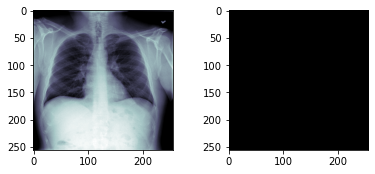

In [48]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[6].reshape(img_size, img_size), cmap=plt.cm.bone)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[6], (img_size, img_size)), cmap="gray")

In [49]:
'This function creates a batch normalization layer with an optinal activation layer'
def bn_act(x, act=True):
    x = tf.keras.layers.BatchNormalization()(x)
    if act == True:
        x = tf.keras.layers.Activation('relu')(x)
    return x

In [50]:
'This function creates a convolutional layer with kernel size of 3 & same padding with stride of 1'
def conv_block(x, filters, kernel_size=3, padding='same', strides=1):
    conv = bn_act(x)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

In [51]:
'This function creates a stem with a kernel size of 3 & same padding with a stride of 1'
def stem(x, filters, kernel_size=3, padding='same', strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size, padding, strides)
    shortcut = Conv2D(filters, kernel_size=1, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([conv, shortcut])
    return output

In [52]:
'This function creates a residual block with a kernel size of 3 & same padding with a stride of 1'
def residual_block(x, filters, kernel_size=3, padding='same', strides=1):
    res = conv_block(x, filters, k_size, padding, strides)
    res = conv_block(res, filters, k_size, padding, 1)
    shortcut = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([shortcut, res])
    return output

In [53]:
"This function creates an upsampling concaenation block"
def upsample_concat_block(x, xskip):
    u = UpSampling2D((2,2))(x)
    c = Concatenate()([u, xskip])
    return c

In [54]:
"This function creates a ResUNet block with dropout rate"

def ResUNet(img_size, dropout_rate=0.1):
    f = [16, 32, 64, 128, 256] * 32
    inputs = Input((img_size, img_size, 1))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    d4 = Dropout(dropout_rate)(d4)
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="linear")(d4)
    model = tf.keras.models.Model(inputs, outputs)
    return model

In [55]:
"This function creates scoring function which calulates the dice co-efficient"

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection = reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (reduce_sum(y_true_f) + reduce_sum(y_pred_f) + smooth)
    return score

"This function calculates the dice loss"

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

"This function calculates the binary cross entropy dice loss"
def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [56]:
"This function helps us in getting the iou vector which is essential for calculating final IoU score"

# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow

def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # takhele the average over all images in batch
    metric /= batch_size
    return metric

"This function helps in calculating the IoU metric score for predictions made by the model"

def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.numpy_function(get_iou_vector, [label, pred > 0.5], tf.float64)

In [57]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
filepath = "/kaggle/working/best_model1.h5"
checkpoint_1 = ModelCheckpoint(filepath,
 monitor="val_dsc",
mode="max",
save_best_only=True,
verbose=1)
tensorboard_1 = TensorBoard(log_dir='graph_one', batch_size=16,update_freq='epoch')
callbacks_1 = [checkpoint_1,tensorboard_1]

In [58]:
model = ResUNet((img_size),dropout_rate=0.1) 
adam = tf.keras.optimizers.Adam(lr = 0.01, epsilon = 0.1)
model.compile(optimizer=adam, loss=bce_dice_loss, metrics=[dsc])

In [59]:
history = model.fit_generator(generator=training_generator, validation_data=validation_generator, epochs=20, callbacks = callbacks_1)

Epoch 1/20
263/263 [==============================] - ETA: 0s - loss: 1.0705 - dsc: 0.0102
Epoch 00001: val_dsc improved from -inf to 0.01385, saving model to /kaggle/working/best_model1.h5
263/263 [==============================] - 188s 715ms/step - loss: 1.0705 - dsc: 0.0102 - val_loss: 1.0381 - val_dsc: 0.0139
Epoch 2/20
263/263 [==============================] - ETA: 0s - loss: 0.9806 - dsc: 0.0689
Epoch 00002: val_dsc improved from 0.01385 to 0.01706, saving model to /kaggle/working/best_model1.h5
263/263 [==============================] - 194s 737ms/step - loss: 0.9806 - dsc: 0.0689 - val_loss: 1.0344 - val_dsc: 0.0171
Epoch 3/20
263/263 [==============================] - ETA: 0s - loss: 0.8963 - dsc: 0.1567
Epoch 00003: val_dsc improved from 0.01706 to 0.05156, saving model to /kaggle/working/best_model1.h5
263/263 [==============================] - 196s 747ms/step - loss: 0.8963 - dsc: 0.1567 - val_loss: 1.0064 - val_dsc: 0.0516
Epoch 4/20
263/263 [=============================

In [60]:
from keras.models import load_model
new_model = load_model('../input/final-weights-p1/ResUNet_weights.h5', compile=False)

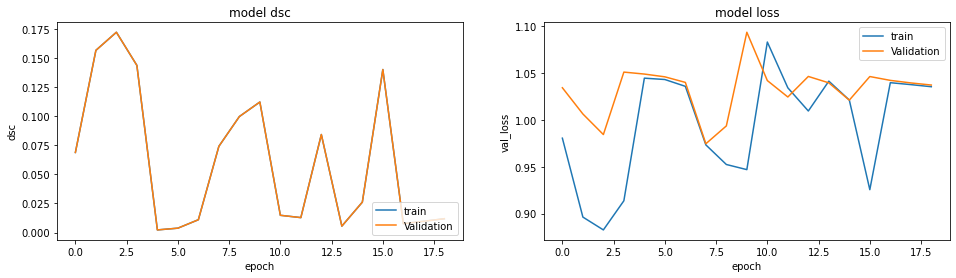

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(history.history['dsc'][1:])
plt.plot(history.history['dsc'][1:])
plt.ylabel('dsc')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='lower right')

plt.title('model dsc')
plt.savefig('dsc.png')

plt.subplot(1,2,2)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper right')
plt.title('model loss')
plt.savefig('loss.png')

In [62]:
"This function helps in making predictions using our model"

def predict_result(model,validation_generator,img_size): 
    # TBD predict both orginal and reflect x
    preds_test1 = model.predict_generator(validation_generator).reshape(-1, img_size, img_size)
    return preds_test1

In [63]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)
train_augment = Compose([
    HorizontalFlip(p = 0.5),
    ShiftScaleRotate(p = 0.5),
    #ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03,p = 0.5),
    OneOf([
        RandomContrast(),
        RandomGamma(),
        RandomBrightness(),
         ], p=0.3),
    OneOf([
        RandomSizedCrop(min_max_height=(176,256), height=256, width=256,p=0.25),
        CLAHE(clip_limit=2.0, tile_grid_size=(32,32),p = 0.4),
         ], p=0.5),
    ToFloat()
])

In [64]:
"This function helps in plotting the predicted masks from our model"

def plot_train(img, mask, pred):
    
    fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,5))
    
    ax[0].imshow(img, cmap=plt.cm.bone)
    ax[0].set_title('Chest X-Ray')
    
    ax[1].imshow(mask, cmap=plt.cm.bone)
    ax[1].set_title('Mask')
    
    ax[2].imshow(pred, cmap=plt.cm.bone)
    ax[2].set_title('Pred Mask')
    
    plt.show()

#### Checking out our model

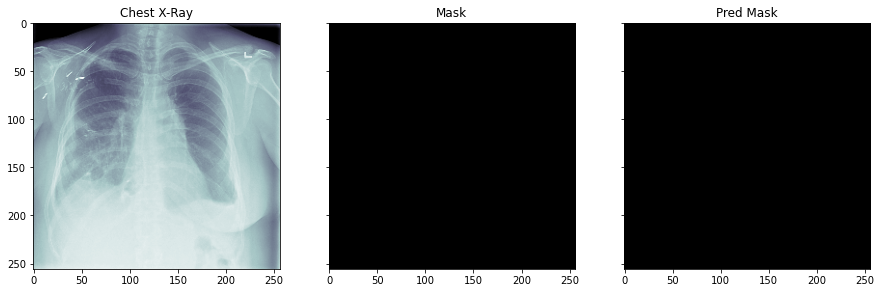

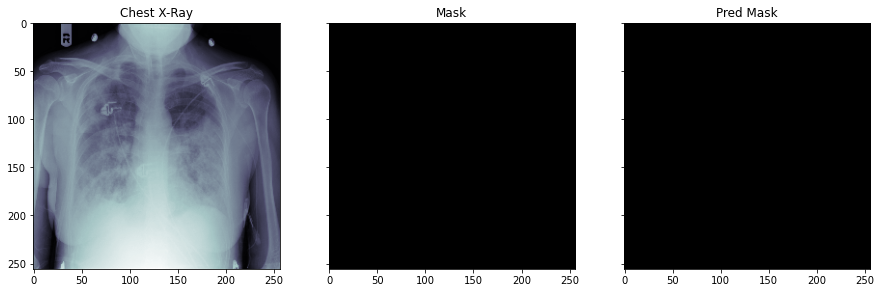

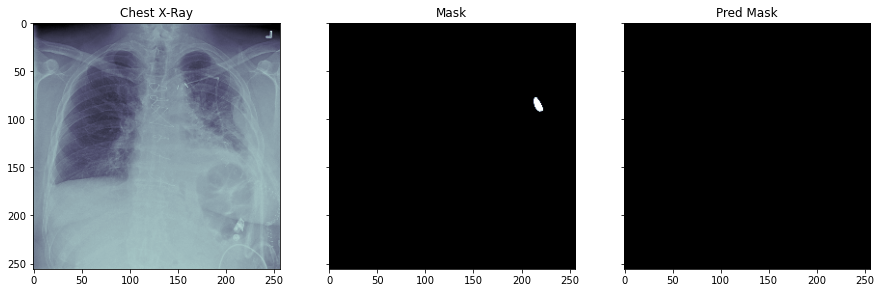

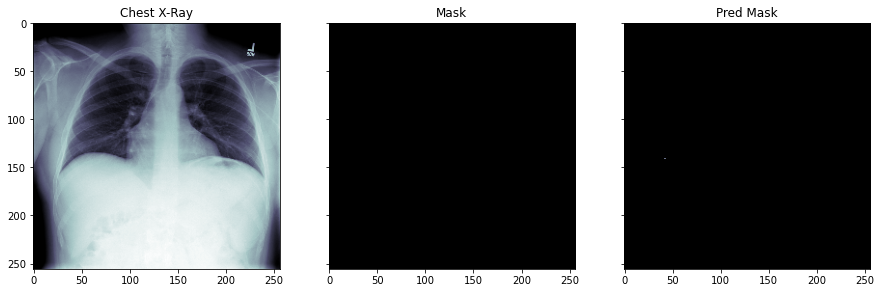

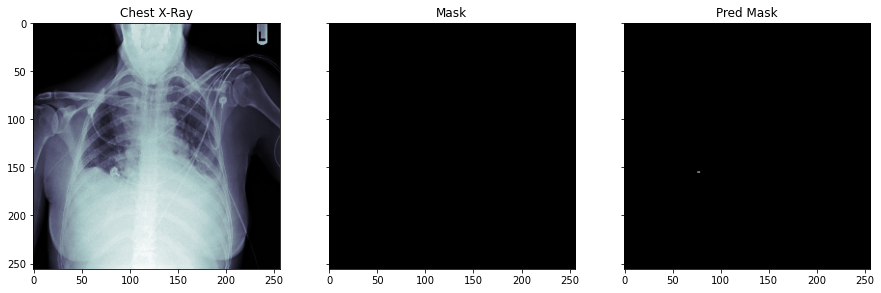

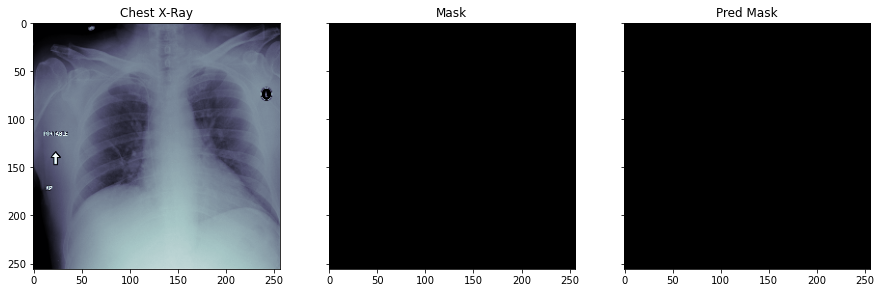

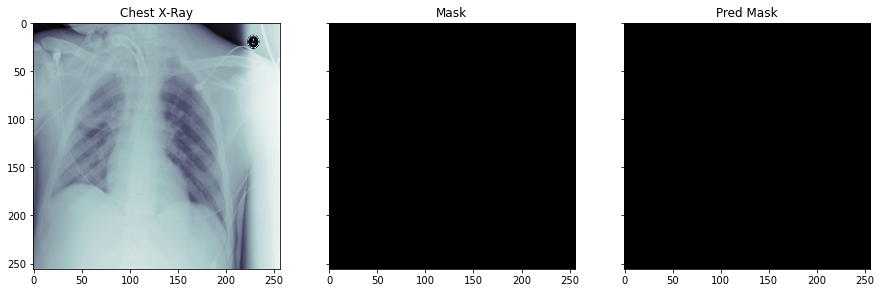

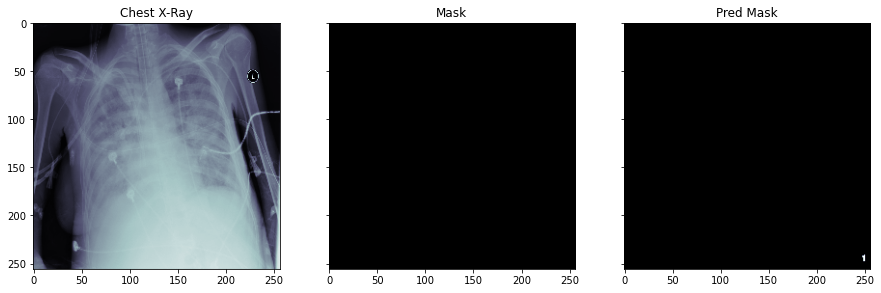

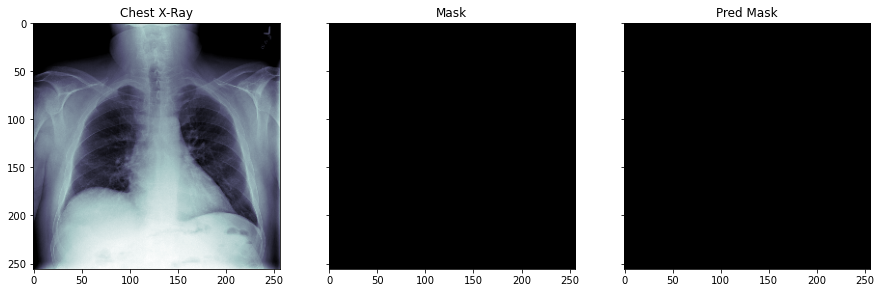

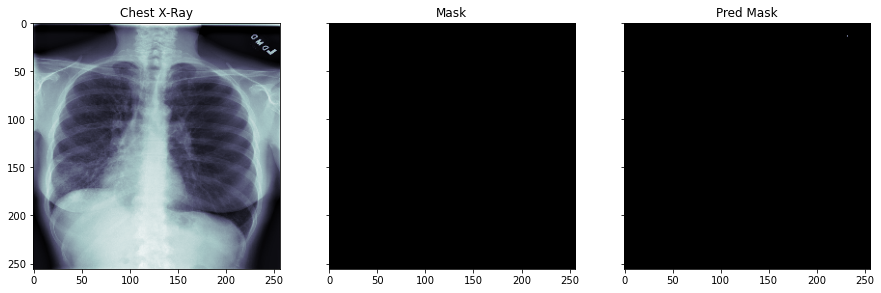

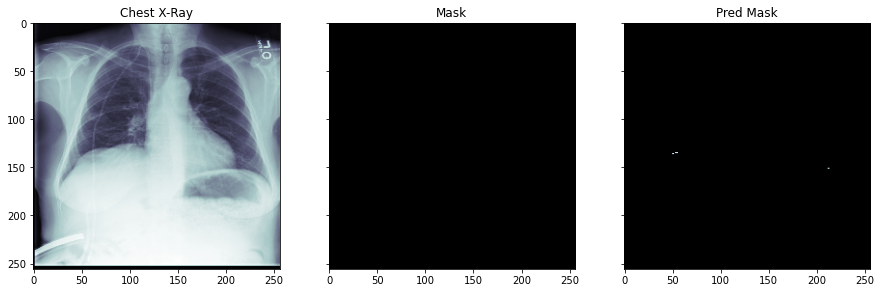

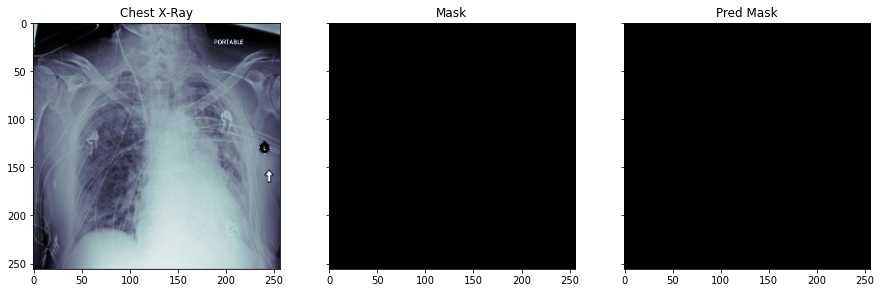

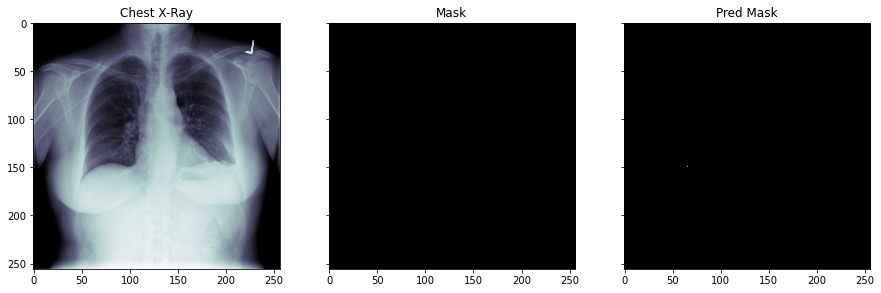

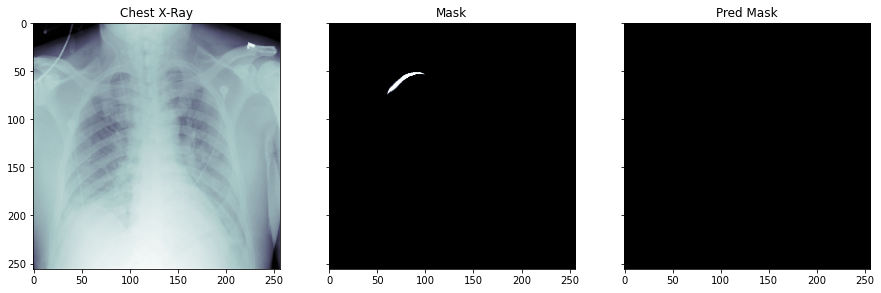

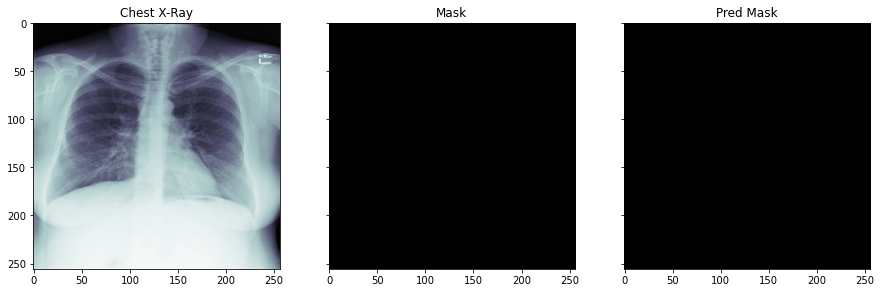

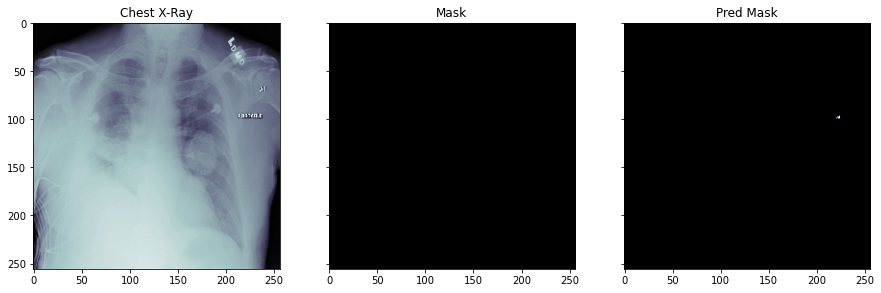

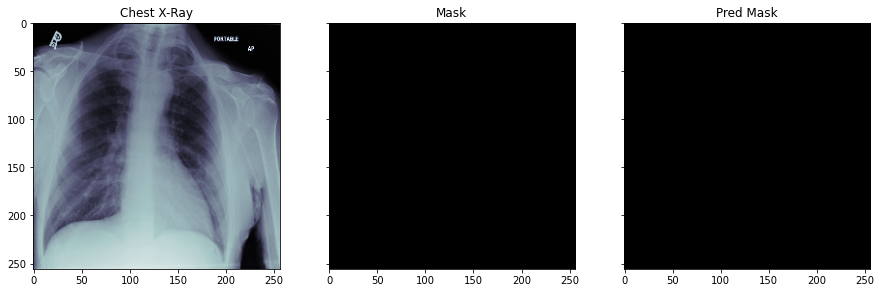

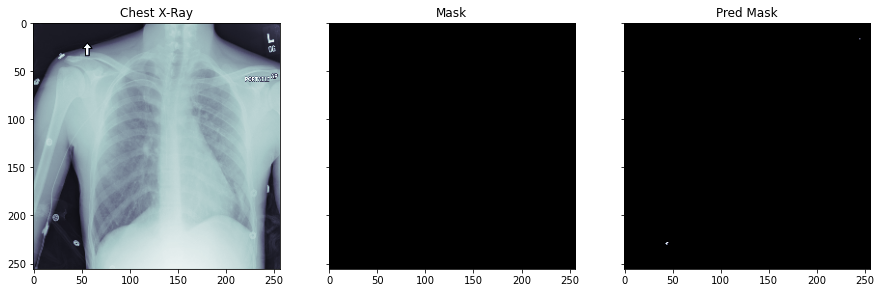

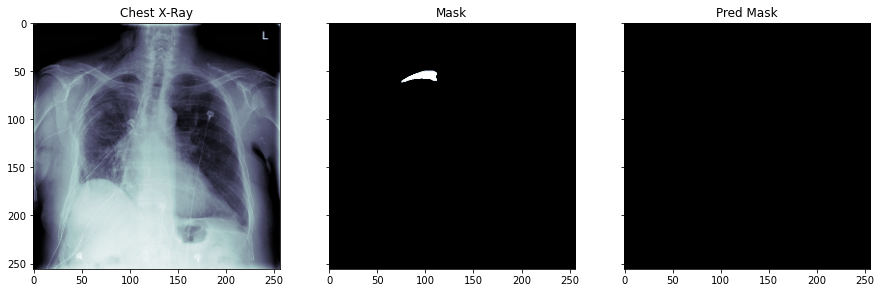

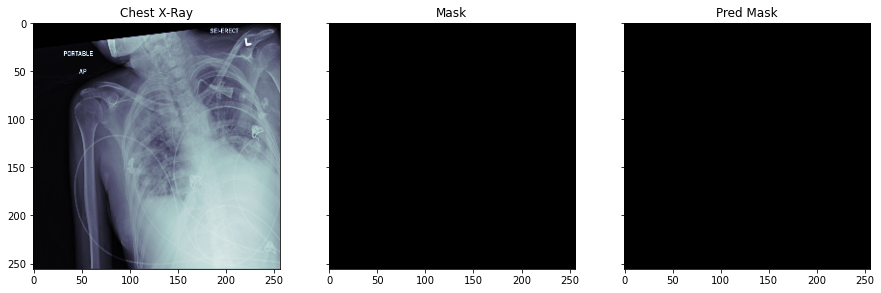

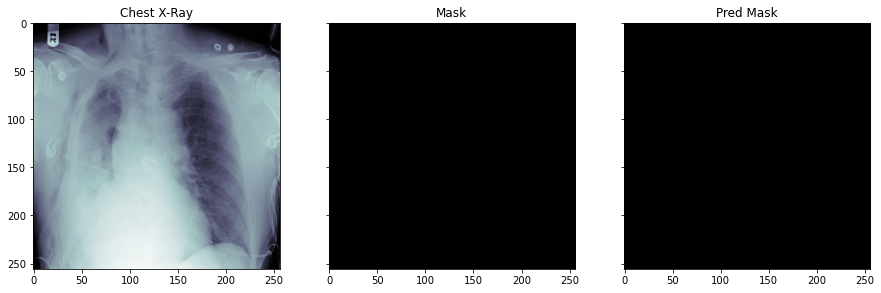

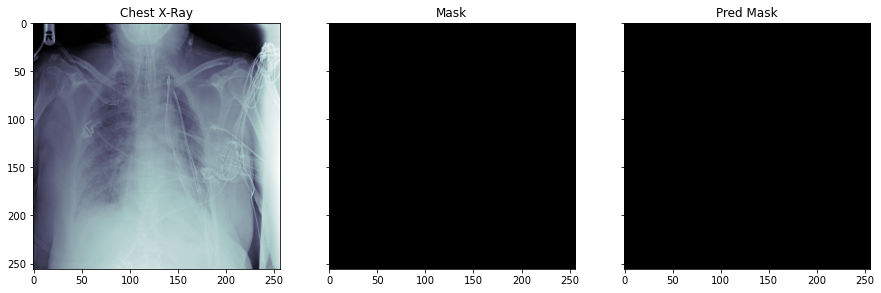

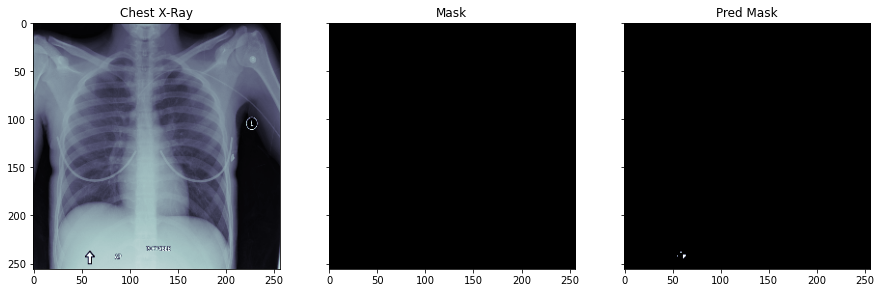

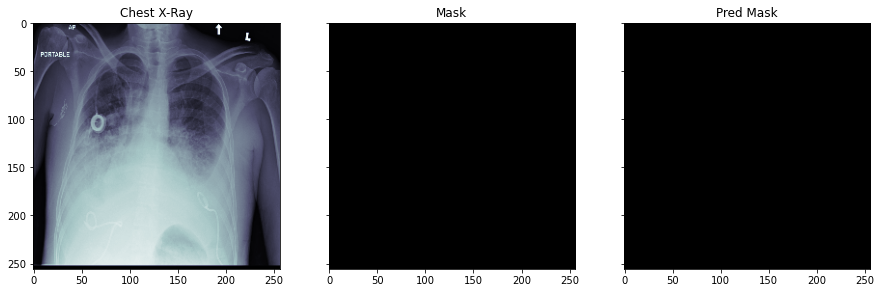

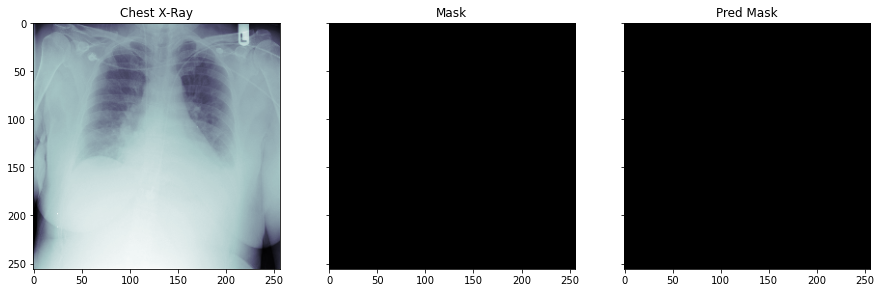

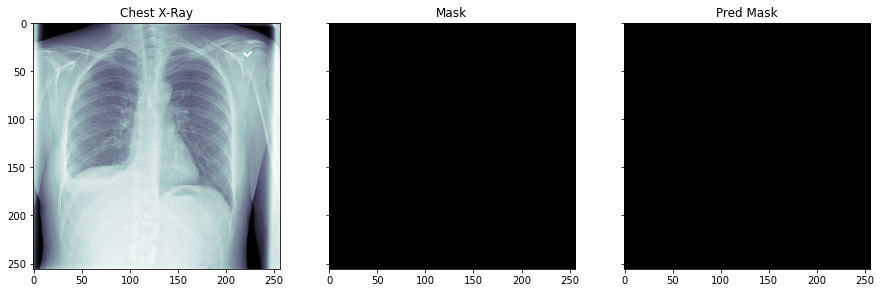

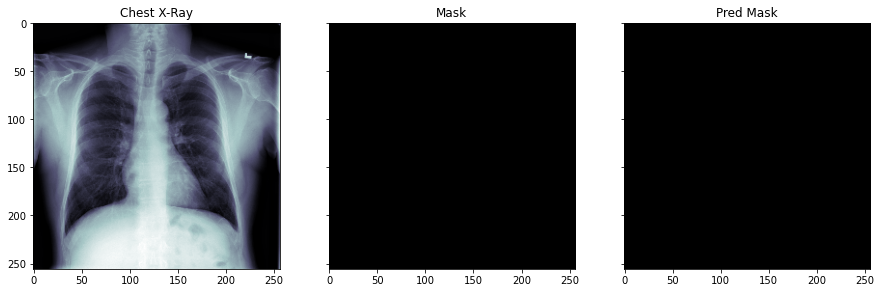

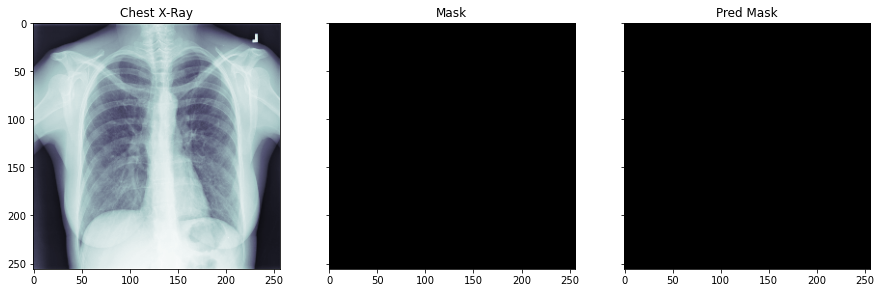

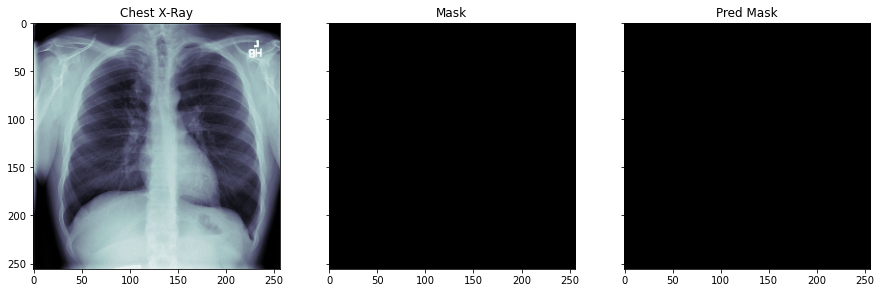

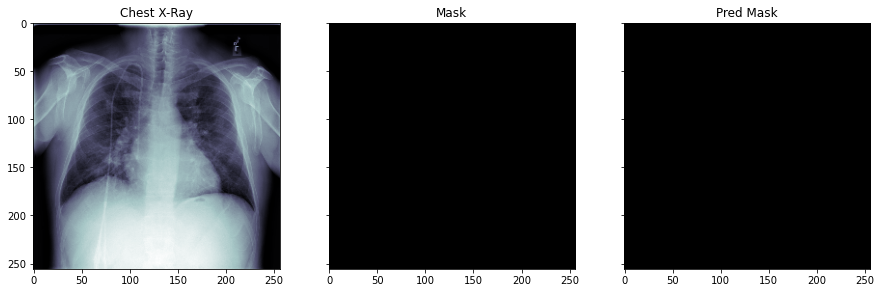

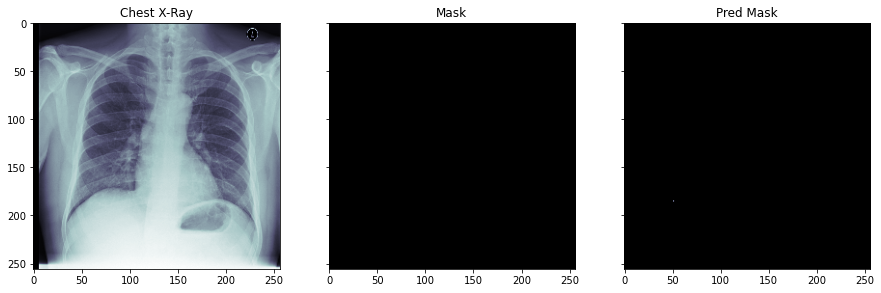

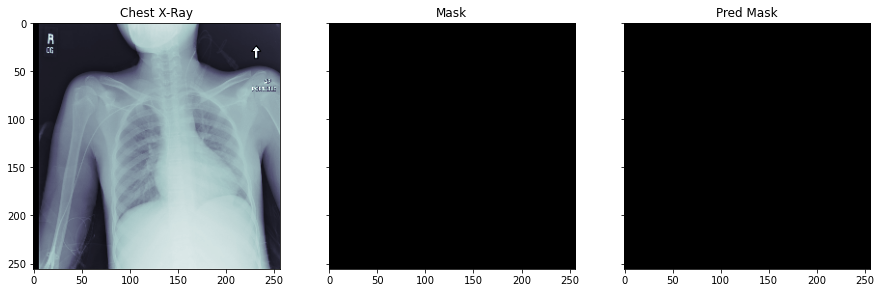

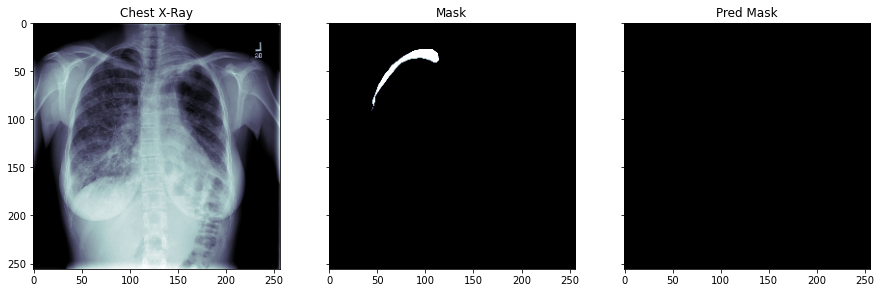

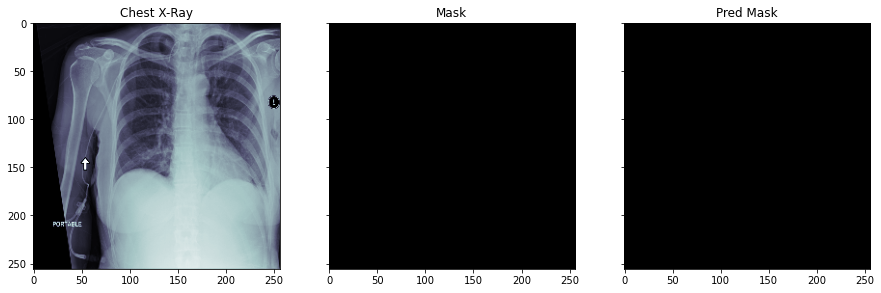

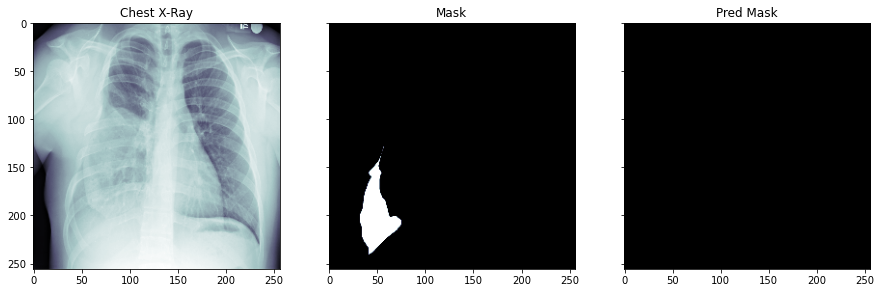

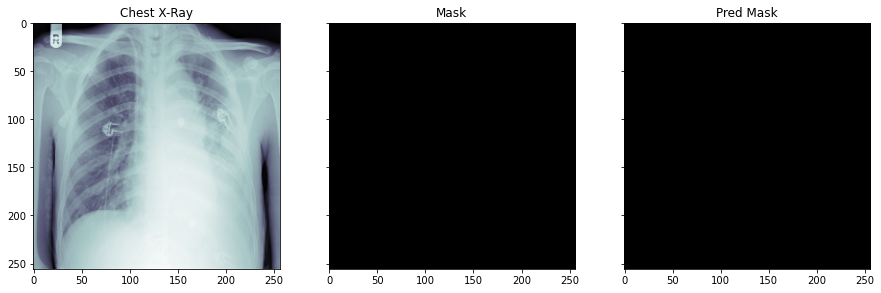

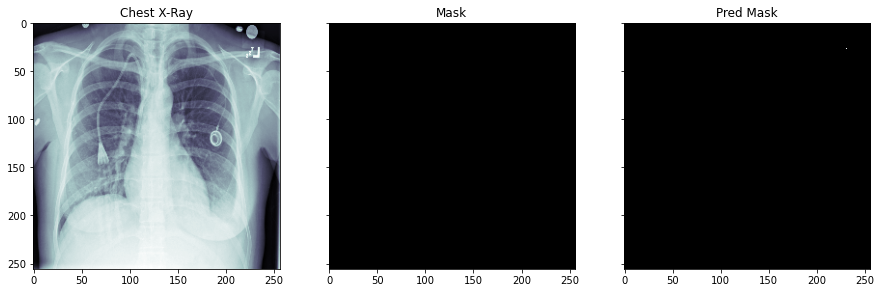

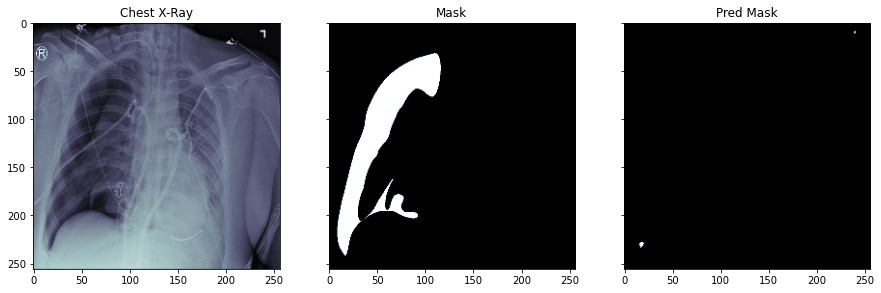

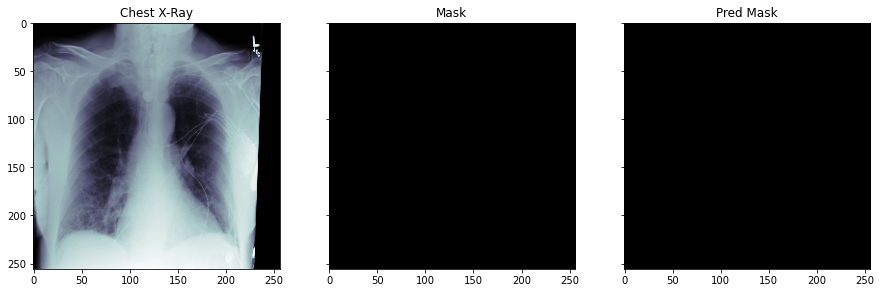

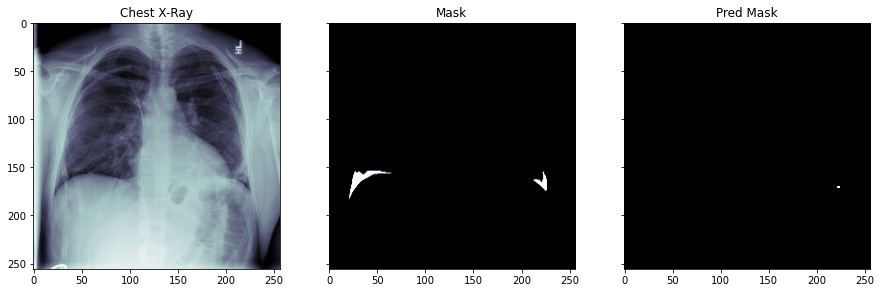

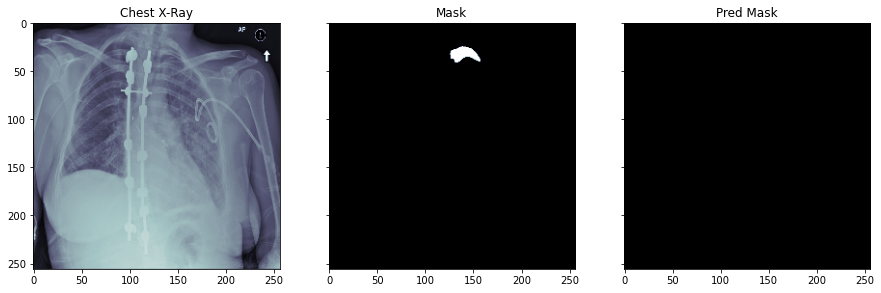

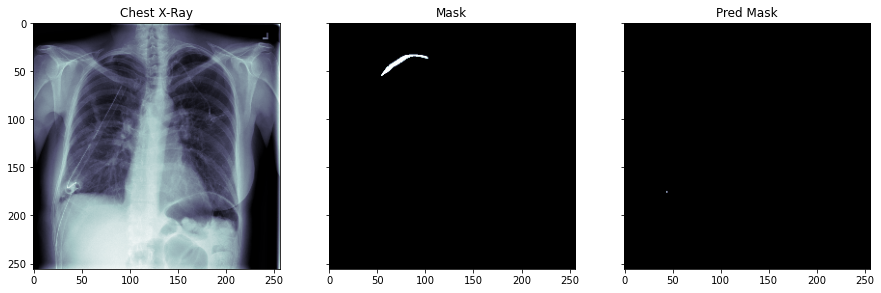

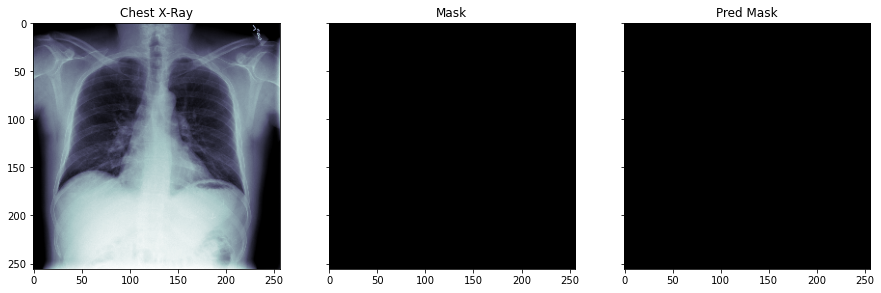

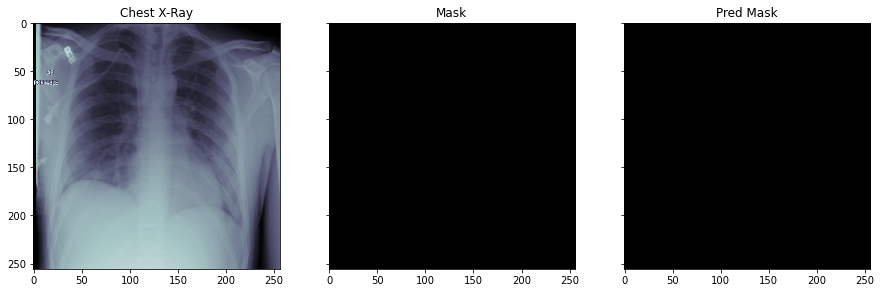

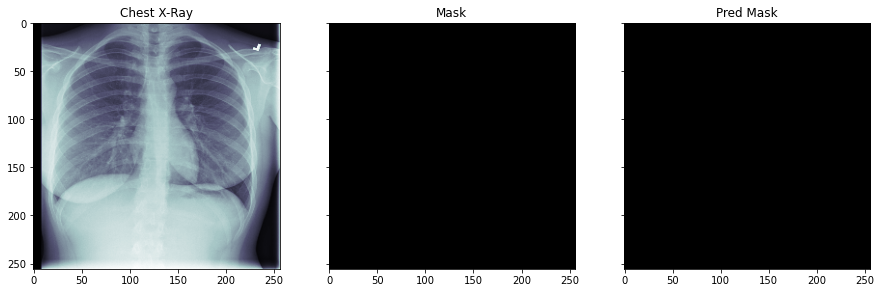

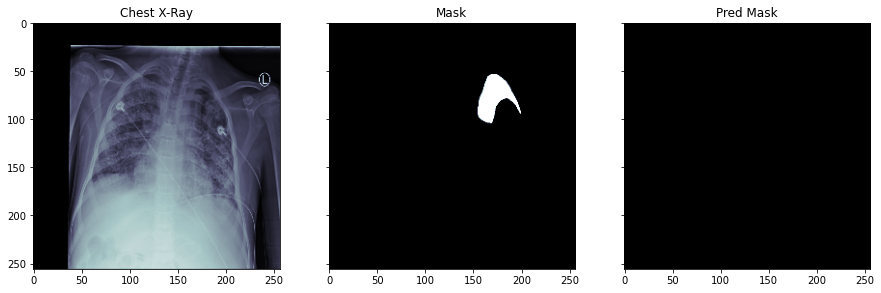

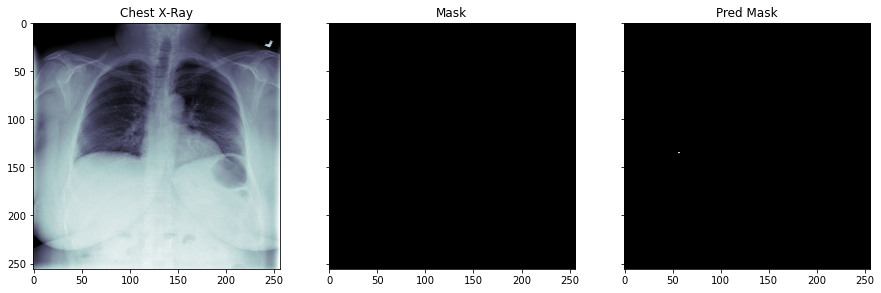

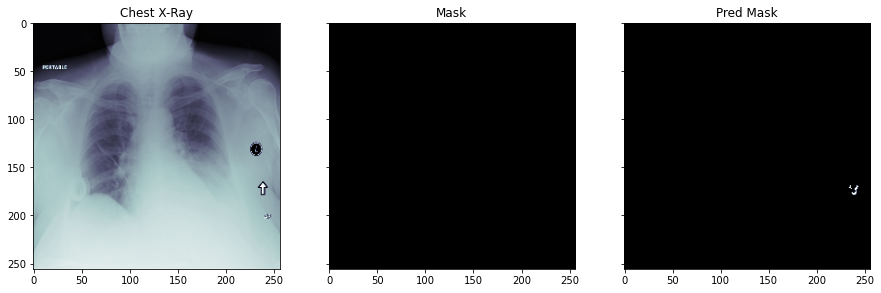

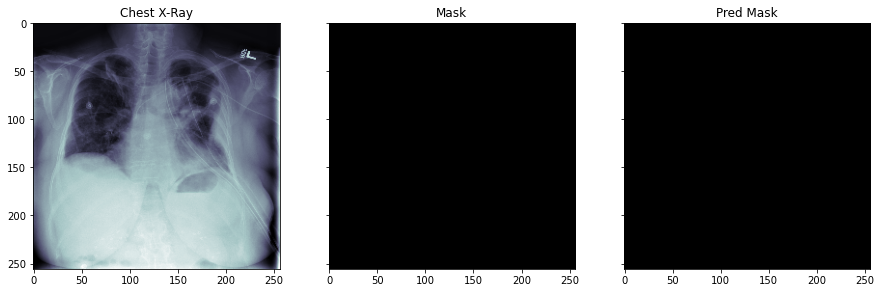

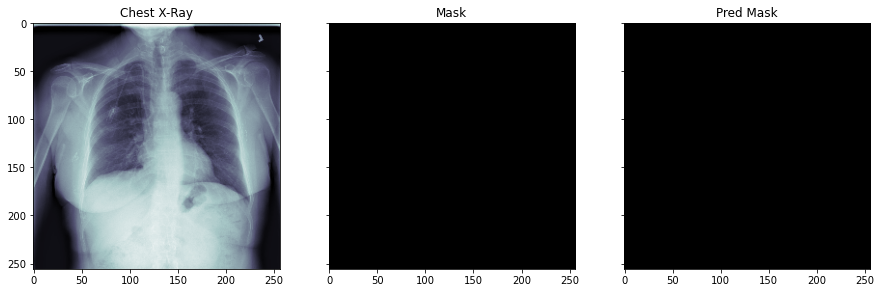

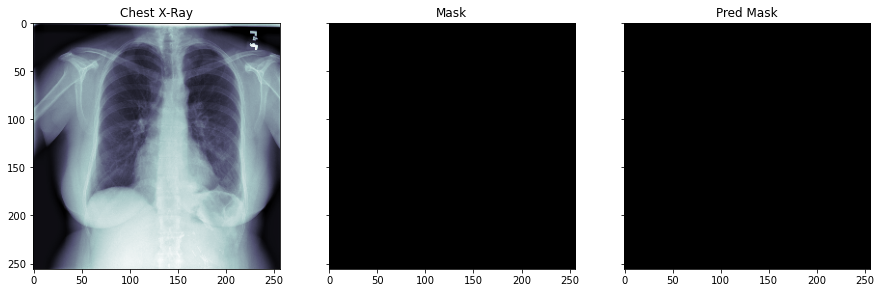

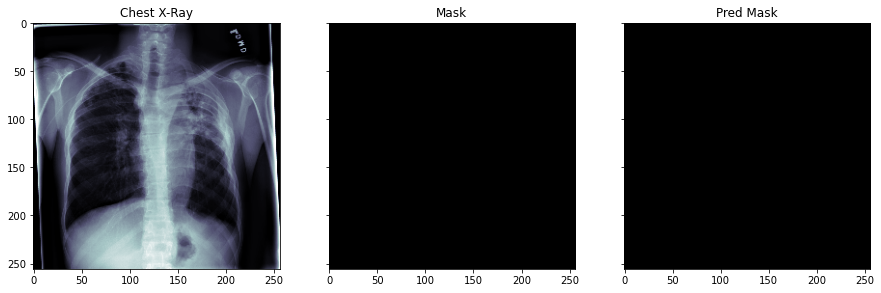

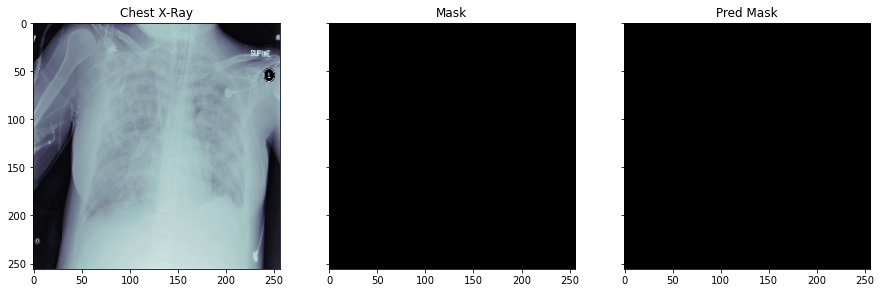

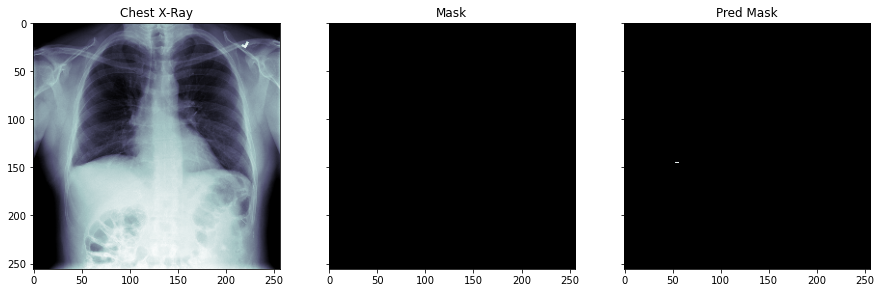

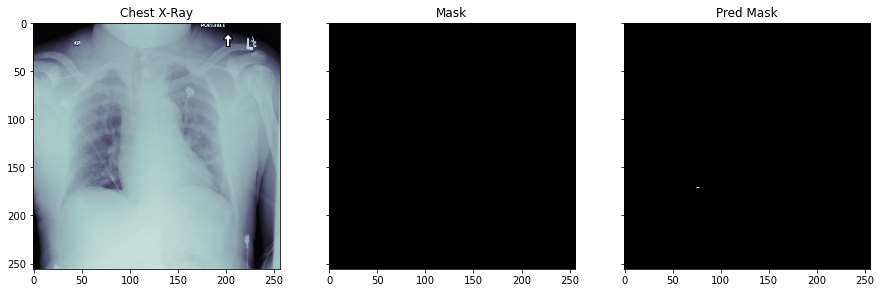

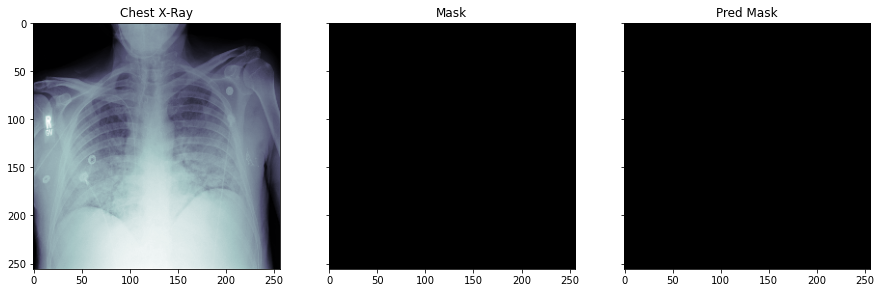

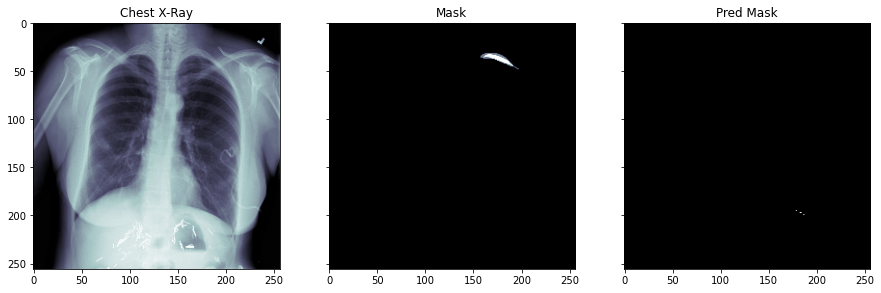

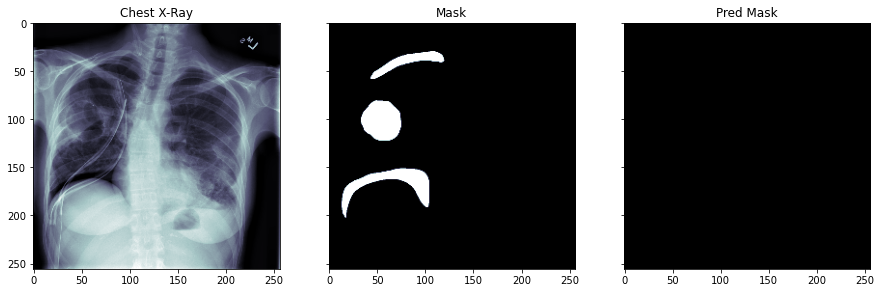

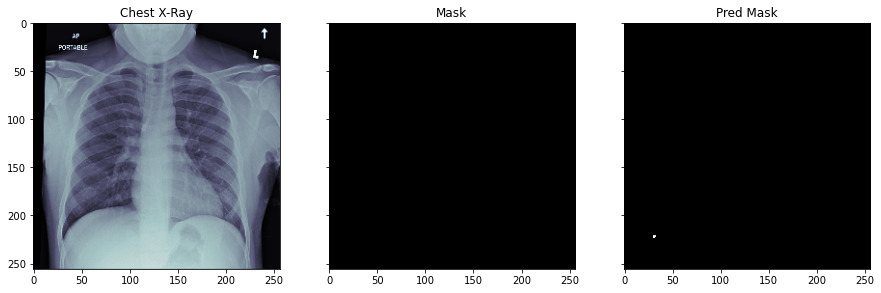

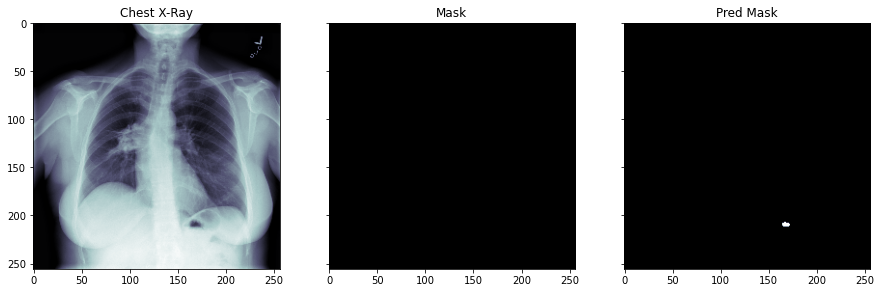

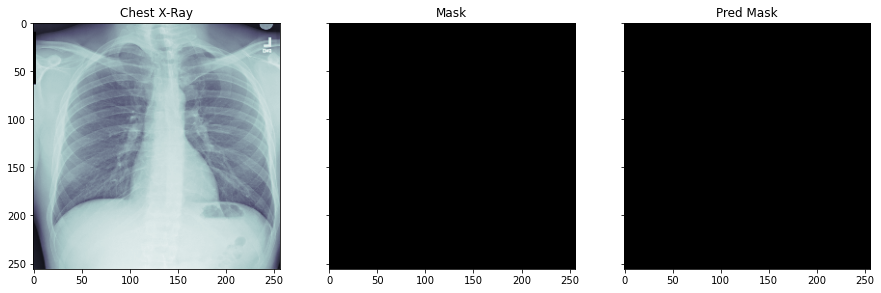

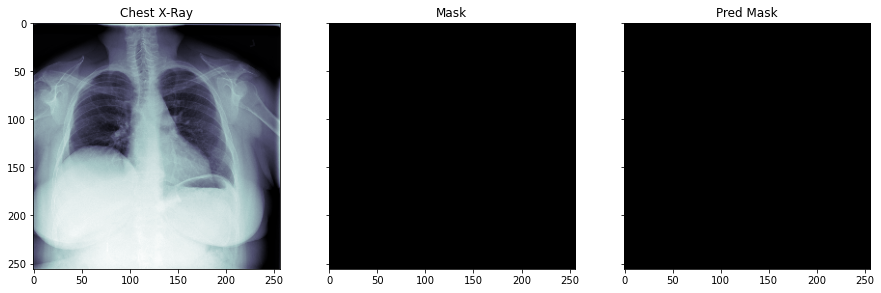

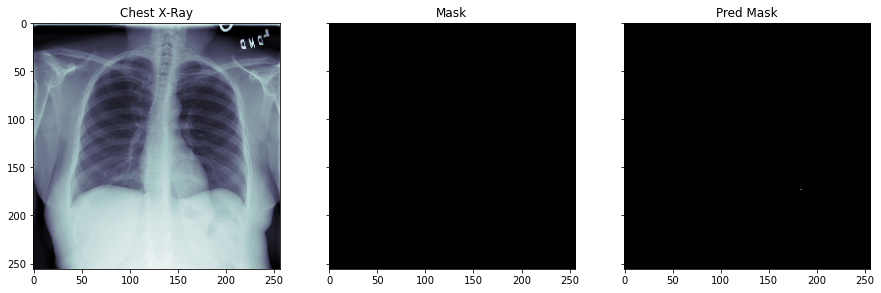

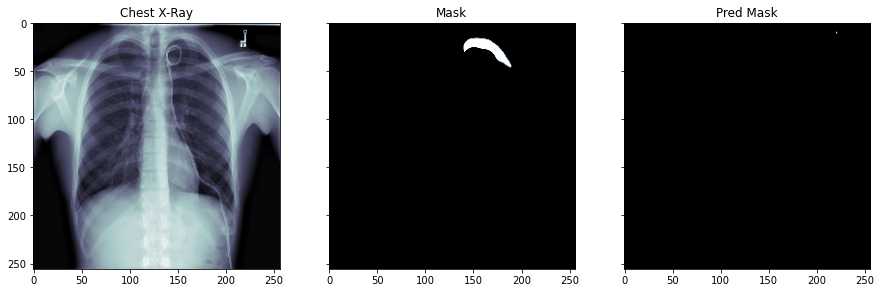

In [65]:
# lets loop over the predictions and print some good-ish results
count = 0
for i in range(0,50):
    if count <= 50:
        x, y = validation_generator.__getitem__(i)
        predictions = model.predict(x)
        for idx, val in enumerate(x):
            #if y[idx].sum() > 0 and count <= 15: 
                img = np.reshape(x[idx]* 255, (img_size, img_size))
                mask = np.reshape(y[idx]* 255, (img_size, img_size))
                pred = np.reshape(predictions[idx], (img_size, img_size))
                pred = pred > 0.5
                pred = pred * 255
                plot_train(img, mask, pred)
                count += 1